Bevi Data Science Co-op Forecasting Exercise
The goal of this exercise is to understand your approach to building an ML model in Python. The following are the aspects that we will be looking at.
● Data Handling and assumptions
● Feature Engineering
● Model Selection
● Accuracy Checks
● Inferences
● Next Steps

Exercise:
- We’ve given you weekly dispense data for six of our machines before October 2023. You need to use this data to create a forecasted weekly total usage for the weeks in months July to November.

- Your forecasts should be based on data till the end of June 2023. The data provided for July 23 to September 23 is only for testing purposes.
Week: 
- Our week starts on Monday and ends on Sunday. The weekend dates you see in the data represent the date a week ended with.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
data = pd.read_excel('co-op dataset.xlsx')

                  ID  TOTAL_DISPENSED  FLAVORED_DISPENSED
WEEK_END_DT                                              
2022-07-10   743BD6E         278418.0         60878.00000
2022-07-10   1CD19D3          28045.0         10517.00004
2022-07-10   D3635AD          23631.0         16203.99998
2022-07-10   A74A256              NaN                 NaN
2022-07-10   BB7EA2A         132980.0         79995.00001


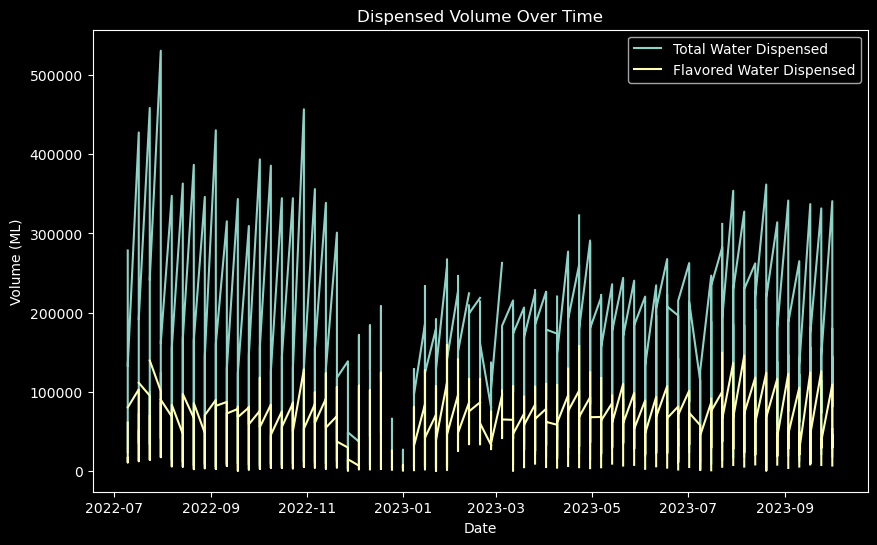

[2.78418e+05 2.80450e+04 2.36310e+04         nan 1.32980e+05 4.27586e+05
 3.47230e+04 7.13000e+04 1.91913e+05 4.58611e+05 3.33450e+04 9.85550e+04
 2.42018e+05 5.30939e+05 4.10090e+04 1.22905e+05 1.61864e+05 3.47483e+05
 2.45610e+04 8.19550e+04 1.35560e+04 1.55185e+05 3.63057e+05 1.10970e+04
 1.11186e+05 6.49410e+04 1.66796e+05 3.86715e+05 6.15600e+03 1.08363e+05
 7.13370e+04 1.64855e+05 3.46104e+05 8.24000e+03 1.02674e+05 8.88140e+04
 1.44552e+05 4.30385e+05 5.21700e+03 1.09067e+05 7.84680e+04 1.60146e+05
 3.15332e+05 8.62300e+03 7.14040e+04 6.82110e+04 1.29305e+05 3.43480e+05
 9.14900e+03 1.26715e+05 8.33750e+04 1.22941e+05 3.09358e+05 7.58700e+03
 1.16143e+05 9.19790e+04 1.46120e+05 3.93642e+05 6.51300e+03 1.86690e+05
 9.35730e+04 1.56082e+05 3.85648e+05 8.29300e+03 1.16417e+05 8.52240e+04
 1.25789e+05 3.44505e+05 7.20200e+03 1.20875e+05 7.37910e+04 1.43686e+05
 3.44463e+05 8.90600e+03 1.43266e+05 8.02150e+04 1.29145e+05 4.56903e+05
 1.15840e+04 1.89339e+05 8.57390e+04 1.29433e+05 3.

/var/folders/1g/0mj97r555d15d54dx2257j7m0000gn/T/ipykernel_7278/2377176514.py:53: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['TOTAL_DISPENSED'].fillna(method='ffill', inplace=True)  # Forward fill missing values


TypeError: agg function failed [how->mean,dtype->object]

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Load the data
data = pd.read_excel('co-op dataset.xlsx')

# Convert 'WEEK_END_DT' to datetime format
data['WEEK_END_DT'] = pd.to_datetime(data['WEEK_END_DT'])

# Set 'WEEK_END_DT' as the index
data.set_index('WEEK_END_DT', inplace=True)

# Display the first few rows of the data
print(data.head())

# Feature Engineering
# Extracting additional features like week of the year, day of the week, etc.
# Feature Engineering
# Extracting additional features like week of the year, day of the week, etc.
data['Week_Number'] = data.index.isocalendar().week
data['Day_of_Week'] = data.index.dayofweek


# Exploratory Data Analysis (EDA)
# Visualize the time series data
plt.figure(figsize=(10, 6))
plt.plot(data['TOTAL_DISPENSED'], label='Total Water Dispensed')
plt.plot(data['FLAVORED_DISPENSED'], label='Flavored Water Dispensed')
plt.title('Dispensed Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (ML)')
plt.legend()
plt.show()

# Convert index back to DatetimeIndex
data.index = pd.to_datetime(data.index)

# Set frequency of the datetime index to weekly ('W')
# Check unique values in 'TOTAL_DISPENSED' column
print(data['TOTAL_DISPENSED'].unique())

# Convert 'TOTAL_DISPENSED' column to numeric, coercing errors to NaN
data['TOTAL_DISPENSED'] = pd.to_numeric(data['TOTAL_DISPENSED'], errors='coerce')

# Handle missing values
data['TOTAL_DISPENSED'].fillna(method='ffill', inplace=True)  # Forward fill missing values

# Resample the data to weekly frequency and calculate mean
data_resampled = data.resample('W').mean()


# Handle missing values
data['TOTAL_DISPENSED'].fillna(method='ffill', inplace=True)  # Forward fill missing values

# Decompose the time series to understand trend, seasonality, and residual components
decomposition = seasonal_decompose(data['TOTAL_DISPENSED'], model='additive')
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')
plt.subplot(4, 1, 3)
plt.plot(decomposition.resid)
plt.title('Residuals')
plt.subplot(4, 1, 4)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.tight_layout()
plt.show()


# Model Selection
# Split data into train and validation sets
train = data.loc[:'2023-06-30']
valid = data.loc['2023-07-01':'2023-09-30']

# Define and train SARIMA model
model = SARIMAX(train['TOTAL_DISPENSED'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_model = model.fit()

# Forecasting
forecast = fit_model.forecast(steps=len(valid))

# Evaluation
mae = mean_absolute_error(valid['TOTAL_DISPENSED'], forecast)
rmse = sqrt(mean_squared_error(valid['TOTAL_DISPENSED'], forecast))
print('MAE:', mae)
print('RMSE:', rmse)

# Plot actual vs. forecasted values
plt.figure(figsize=(10, 6))
plt.plot(valid['TOTAL_DISPENSED'], label='Actual')
plt.plot(valid.index, forecast, label='Forecast', color='red')
plt.title('Actual vs. Forecasted Total Dispensed Volume')
plt.xlabel('Date')
plt.ylabel('Volume (ML)')
plt.legend()
plt.show()

# Repeat the same process for FLAVORED_DISPENSED if time permits
